In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.autograd as autograd
from torch import Tensor
import torch.nn.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import tqdm as tqdm
import torch
import numpy as np
import os
import re
import pandas as pd

In [22]:

def processImages(imgDirectory: str, saveDirectory: str = os.getcwd(), returnDF:bool = False) -> pd.DataFrame | None:
    """
    Process binarized predicted mask images saved in a directory, implement checks, 
    and create a `'submission.csv'` submission file containing image status and mask indices.

    **Do NOT modify this function.**

    Parameters
    ----------
    imgDirectory : str
        The directory containing the images to be processed. It should have exactly 127 .png files.
        When you save your model's predicted masks, make sure the pixel values 
        are either 0 or 255, and save it as a .png file (preferably using PIL).
    saveDirectory : str, optional
        The directory where the resulting DataFrame will be saved as a CSV file. 
        Defaults to the current directory.
    returnDF : bool, optional
        Whether to return the DataFrame. Defaults to False.

    Returns
    -------
    df: A DataFrame with columns 'imageID', 'status', and 'mask', indexed by 'imageID' if `returnDF` is True, else None

    Raises
    ------
    ValueError
        If the number of .png files in `imgDirectory` is not 127,
        if any image is not binary, or if any image is not 512x512 pixels.

    Example Usage
    -------------
    `processImages('path/to/img/folder', 'path/to/save/folder')`
    """

    files = [f for f in os.listdir(imgDirectory) if f.endswith('.png')]  # Get all .png files in the directory
    if len(files) != 127:
        raise ValueError("Directory must contain exactly 127 .png files")

    files.sort(key=lambda x: int(re.search(r'\d+', x.split('.')[0]).group()))  # Sort by the numeric part of the filename without extension

    data = []  # List of dictionaries to be converted to DataFrame
    for file in files:
        imgPath = os.path.join(imgDirectory, file)
        img = np.array(Image.open(imgPath).convert('L'), dtype=np.uint8)

        # Check if image is binary
        if not np.array_equal(img, img.astype(bool).astype(img.dtype) * 255):
            raise ValueError(f"Image {file} is not binary")
        # Check image size
        if img.shape != (512, 512):
            raise ValueError(f"Image {file} is not of size 512x512")

        status = 1 if np.any(img == 255) else 0  # Determine status of image
        maskIndices = ' '.join(map(str, np.nonzero(img.flatten() == 255)[0])) if status else '-100'

        data.append({'imageID': int(re.search(r'\d+', file).group()), 'status': status, 'mask': maskIndices})

    df = pd.DataFrame(data).set_index('imageID')
    df.to_csv(os.path.join(saveDirectory, 'submission.csv'))

    if returnDF: return df


In [23]:
processImages(
    imgDirectory="/Users/sujitsilas/Desktop/UCLA/Spring 2024/BE M224B Advances in Imaging Informatics /BE224_Spring2024_Data/generatedMasks",
    saveDirectory="/Users/sujitsilas/Desktop/UCLA/Spring 2024/BE M224B Advances in Imaging Informatics /BE224_Spring2024_Data/generatedMasks")

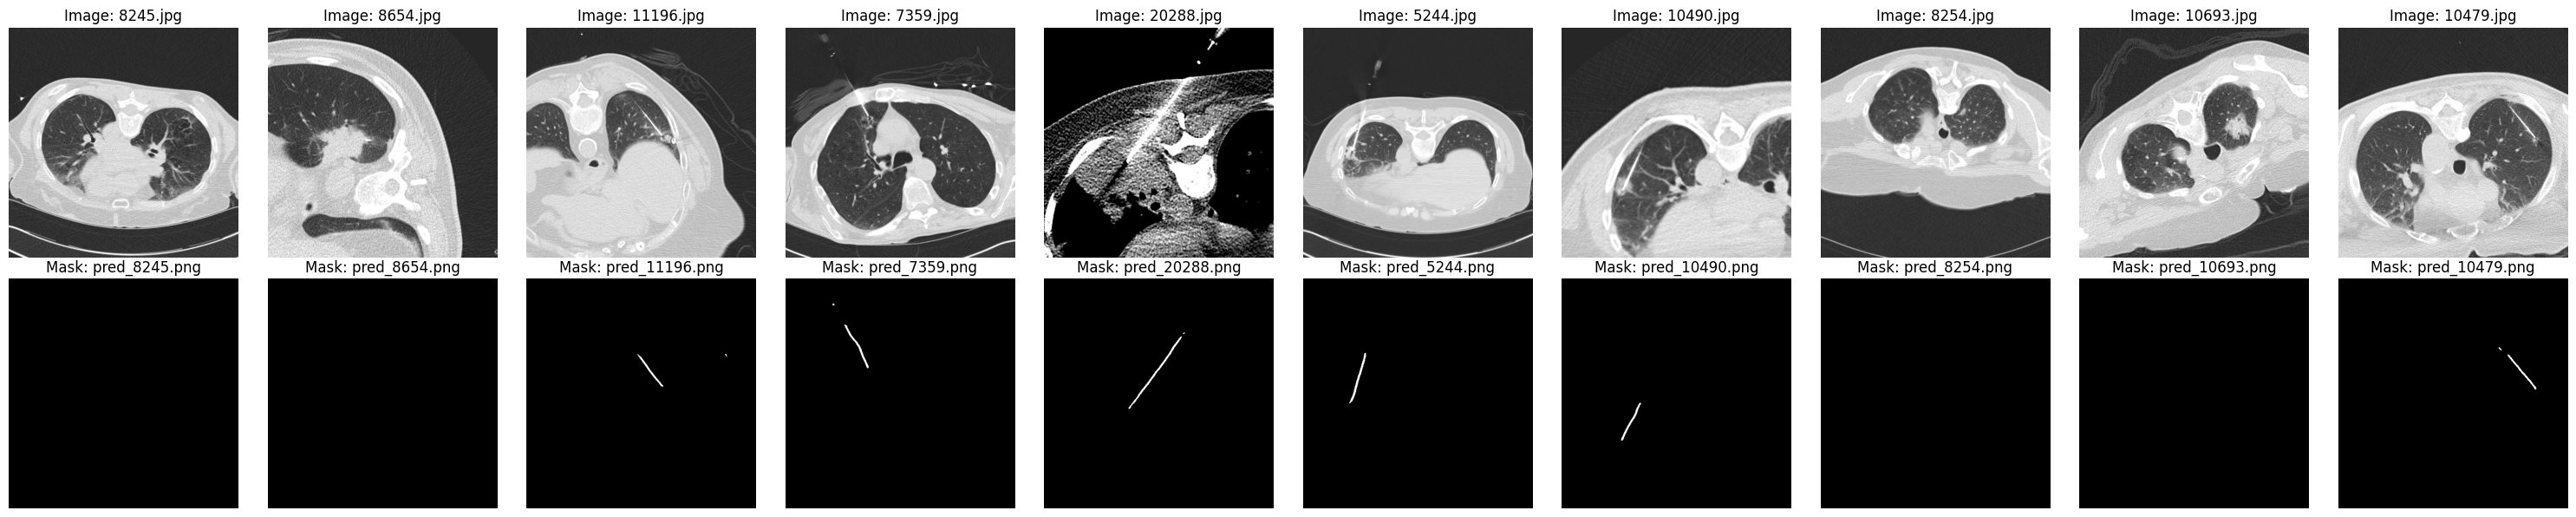

In [9]:
import os
import random
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def plot_random_images_and_masks(image_dir, mask_dir, num_samples=10):
    # List all files in the image and mask directories
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    mask_files = [f for f in os.listdir(mask_dir) if f.startswith('pred_') and f.endswith('.png')]

    # Sort files numerically based on the numeric part of the filename
    image_files.sort(key=lambda x: int(re.search(r'\d+', x.split('.')[0]).group()))
    mask_files.sort(key=lambda x: int(re.search(r'\d+', x.split('_')[1].split('.')[0]).group()))

    # Create dictionaries to map base names to filenames
    image_dict = {os.path.splitext(f)[0]: f for f in image_files}
    mask_dict = {f.split('_')[1].split('.')[0]: f for f in mask_files}
    
    # Find common base names
    common_base_names = list(set(image_dict.keys()).intersection(mask_dict.keys()))

    # Ensure there are enough files
    if len(common_base_names) < num_samples:
        raise ValueError(f"Not enough matching images/masks. Found {len(common_base_names)} matching pairs.")
    
    # Randomly select num_samples base names
    selected_base_names = random.sample(common_base_names, num_samples)
    
    # Set up the plot
    fig, axes = plt.subplots(2, num_samples, figsize=(3 * num_samples, 6))

    for i, base_name in enumerate(selected_base_names):
        image_file = image_dict[base_name]
        mask_file = mask_dict[base_name]
        
        # Load the image and mask
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        
        # Plot the image and mask
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Image: {image_file}")
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f"Mask: {mask_file}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_dir = "/Users/sujitsilas/Desktop/UCLA/Spring 2024/BE M224B Advances in Imaging Informatics /BE224_Spring2024_Data/testImages/testImages"
mask_dir = "/Users/sujitsilas/Desktop/UCLA/Spring 2024/BE M224B Advances in Imaging Informatics /BE224_Spring2024_Data/UNET_E100_B10_0.579"
plot_random_images_and_masks(image_dir, mask_dir)


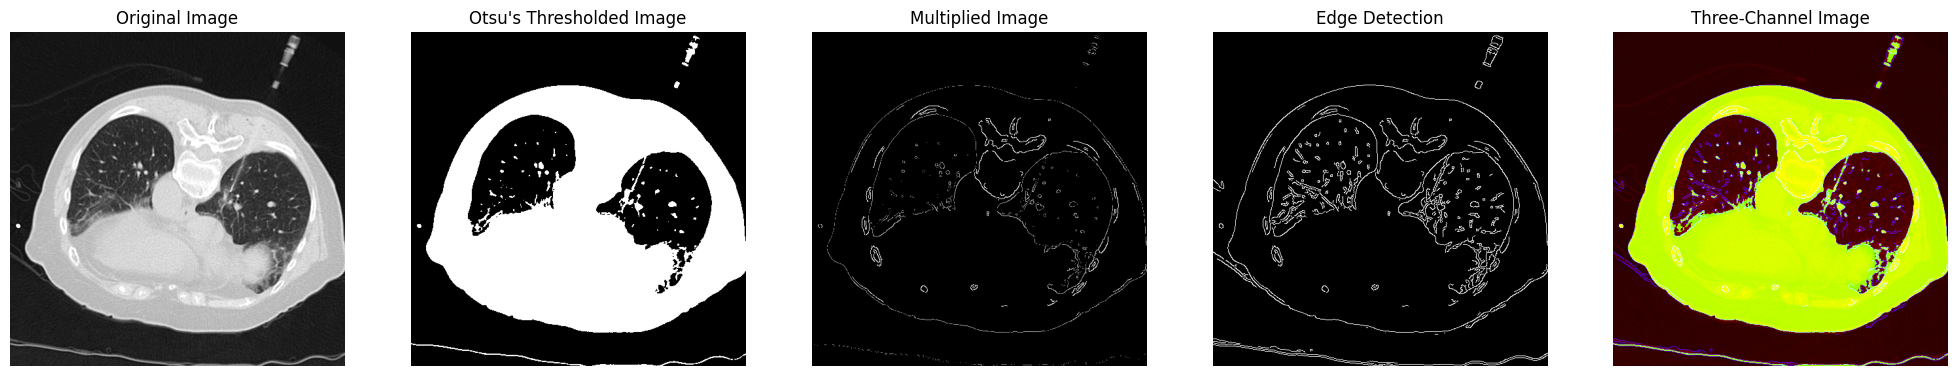

In [10]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/Users/sujitsilas/Desktop/UCLA/Spring 2024/BE M224B Advances in Imaging Informatics /BE224_Spring2024_Data/testImages/testImages/14227.jpg"

# Load the image in grayscale
image = np.array(Image.open(img_path).convert("L"), dtype=np.uint8)

# Apply Otsu's thresholding to create a binary mask from the image
_, otsu_thresh_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply Canny edge detection
edges = cv2.Canny(image, 100, 200)

# Multiply the original image with the Otsu thresholded image
multiplied_image = cv2.bitwise_and(edges, image, mask=otsu_thresh_image)


# Create a three-channel image combining the original, multiplied, and thresholded images
three_channel_image = np.stack([image,otsu_thresh_image, edges], axis=-1)


# Plot the images
plt.figure(figsize=(25, 10))

plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(otsu_thresh_image, cmap='gray')
plt.title("Otsu's Thresholded Image")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(multiplied_image, cmap='gray')
plt.title('Multiplied Image')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(three_channel_image)
plt.title('Three-Channel Image')
plt.axis('off')

plt.show()
